# BT 5153: Team Loren Ipsum - Image tagging system: Electronics Category only

## Reading Datasets and importing library
* The merged data file uploaded here is a 220 MB file which was created from the original datasets downloaded from this link: https://nijianmo.github.io/amazon/index.html
* This merged file was created using 2 files downloaded from the above link: 1. The review file, which contains the review data of a product and 2. The product metadata file, which contains information about the product
    * The review file has been chosen to incorporate "realism" into our dataset. Images from review file are images that we expect from users to be uploaded onto a C2C second-hand marketplace portal

In [1]:
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re #for splitting tags
import urllib #Extracting images from url's
import cv2   #For image processing
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss
from multiprocessing.pool import Pool
import gc

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
#from google.colab import drive
#drive.mount('/content/drive')

/kaggle/input/amazon-merged-dataset/mergeddata (1).csv


In [2]:
df = pd.read_csv('/kaggle/input/amazon-merged-dataset/mergeddata (1).csv')

In [3]:
#print(df)
print(len(df))
print(df.head)

112066
<bound method NDFrame.head of               asin                                      review_images  \
0       0511189877  ['https://images-na.ssl-images-amazon.com/imag...   
1       0972683275  ['https://images-na.ssl-images-amazon.com/imag...   
2       0972683275  ['https://images-na.ssl-images-amazon.com/imag...   
3       0972683275  ['https://images-na.ssl-images-amazon.com/imag...   
4       0972683275  ['https://images-na.ssl-images-amazon.com/imag...   
...            ...                                                ...   
112061  B01HICMC3A  ['https://images-na.ssl-images-amazon.com/imag...   
112062  B01HICMC3A  ['https://images-na.ssl-images-amazon.com/imag...   
112063  B01HIS365W  ['https://images-na.ssl-images-amazon.com/imag...   
112064  B01HIW2XPM  ['https://images-na.ssl-images-amazon.com/imag...   
112065  B01HIYOC0E  ['https://images-na.ssl-images-amazon.com/imag...   

                                                 category  \
0       ['Electronics', '

## Generating and Keeping only relevant tags (using Count Vectoriser)
* We use the "category" column of the dataset above to generate tags. Tags which appear atleast 0.5% of the times across entire dataset 

In [4]:
# Data might have duplicate rows due to multiple images - creating a category dataset with unique product and category

df_cat = df[['asin','category']]
df_cat.drop_duplicates(inplace = True)
#df_cat.reset_index()
df_cat.head()

print("Unique products with their categories are:", len(df_cat))
print(df_cat)

Unique products with their categories are: 39965
              asin                                           category
0       0511189877  ['Electronics', 'Accessories & Supplies', 'Aud...
1       0972683275  ['Electronics', 'Accessories & Supplies', 'Aud...
8       106171327X  ['Electronics', 'Computers & Accessories', 'Co...
10      140053271X  ['Electronics', 'eBook Readers & Accessories',...
11      1400501466  ['Electronics', 'Computers & Accessories', 'Co...
...            ...                                                ...
112060  B01HI9ZK8M  ['Electronics', 'Accessories & Supplies', 'Aud...
112061  B01HICMC3A  ['Electronics', 'Computers & Accessories', 'Ne...
112063  B01HIS365W  ['Electronics', 'Computers & Accessories', 'Co...
112064  B01HIW2XPM  ['Electronics', 'Computers & Accessories', 'Co...
112065  B01HIYOC0E  ['Electronics', 'Accessories & Supplies', 'Cor...

[39965 rows x 2 columns]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [5]:
def my_tokenizer(s):
    #s = s.replace(', ',',') # So that blank does NOT become an encoding
    s = re.split(', ',s) #Seperate tags after each comma
    #s = s.split('/&') #Seperate tags after each &
    return s

# Replace initial and starting and '\'' characters
df_cat['category'] = df_cat['category'].apply(lambda x: x.replace('[','').replace(']','').replace('\'',''))

# Implementing vectoriser - without any 
vec = CountVectorizer(tokenizer = my_tokenizer, 
                      lowercase = True,
                      min_df = 0.05, # Should appear as a tag in atleast 5% of all products
                      max_features = 100,  # a maximum of top 250 tags after the above exclusion will be considered,
                      stop_words = ['electronics'] #THIS STOP-WORD WOULD NOT BE USED ONCE EXPANDING ONTO OTHER CATEGORIES
                     )
X = vec.fit_transform(df_cat['category'])
tags = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

# Some tags are repeating causing vectoriser > 1 --> they are being replaced by 1
tags.mask(tags > 1, 1, inplace = True)

print(tags.head())
print("~2100 individual tags are now reduced to: ",tags.shape)
                   
## Joining tags to df_cat
df_vectoriser = pd.concat([df_cat.reset_index(drop=True),tags.reset_index(drop=True)], axis = 1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


   accessories  accessories & supplies  audio & video accessories  bags  \
0            0                       1                          1     0   
1            0                       1                          1     0   
2            0                       0                          0     0   
3            0                       0                          0     0   
4            0                       0                          0     0   

   cables & interconnects  camera & photo  cases & sleeves  \
0                       0               0                0   
1                       0               0                0   
2                       0               0                0   
3                       0               0                0   
4                       0               0                0   

   computer accessories & peripherals  computer components  \
0                                   0                    0   
1                                   0               

In [6]:
## Viewing concat dataset
df_vectoriser

,asin,category,accessories,accessories & supplies,audio & video accessories,bags,cables & interconnects,camera & photo,cases & sleeves,computer accessories & peripherals,computer components,computers & accessories,headphones,laptop accessories,portable audio & video,tablet accessories
0,0511189877,"Electronics, Accessories & Supplies, Audio & V...",0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,0972683275,"Electronics, Accessories & Supplies, Audio & V...",0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,106171327X,"Electronics, Computers & Accessories, Computer...",0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,140053271X,"Electronics, eBook Readers & Accessories, eBoo...",0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1400501466,"Electronics, Computers & Accessories, Computer...",0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39960,B01HI9ZK8M,"Electronics, Accessories & Supplies, Audio & V...",0,1,1,0,0,0,0,0,0,0,0,0,0,0
39961,B01HICMC3A,"Electronics, Computers & Accessories, Networki...",0,0,0,0,0,0,0,0,0,1,0,0,0,0
39962,B01HIS365W,"Electronics, Computers & Accessories, Computer...",0,0,0,0,0,0,0,1,0,1,0,0,0,0
39963,B01HIW2XPM,"Electronics, Computers & Accessories, Computer...",0,0,0,0,0,0,0,0,1,1,0,0,0,0


## Building model

In [7]:
# Libraries for building model
import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.applications import densenet, VGG16

Using TensorFlow backend.


### Some more data manipulation (Sequential steps)
* This is done because each row has multiple URL's of images, so each URL becomes 1 row of data
* Only keep products which have >1 "metadata" images - this check is introduced to ensure that products are genuine and the seller has put some effort to list the image online
* Randomly selecting 2 images from metadata and 1 image from the review data: This is done because downloading all the images takes it to 1M+ images

In [8]:
# We have observed multiple review Url's for 1 product, so dataset is exploded such that each URL becomes a row
df_url1 = df[['asin','review_images']]
df_url1 = df_url1.drop_duplicates().reset_index(drop = True)
df_url2 = df[['asin','clean_image']]
df_url2 = df_url2.drop_duplicates().reset_index(drop = True)
url_clean1 = lambda x: x['review_images'].replace('\'','').replace('[','').replace(']','')
url_clean2 = lambda x: x['clean_image'].replace('\'','').replace('[','').replace(']','')
df_url1['clean_review_url'] = df_url1.apply(url_clean1, axis = 1)
df_url2['clean_metadata_url'] = df_url2.apply(url_clean2, axis = 1)
new_df1 = pd.DataFrame(df_url1.clean_review_url.str.split(', ').tolist(), index=df_url1.asin).stack()  
new_df2 = pd.DataFrame(df_url2.clean_metadata_url.str.split(', ').tolist(), index=df_url2.asin).stack()
#print(new_df2)
new_df1 = new_df1.reset_index([0, 'asin'])
new_df1.columns = ['asin', 'image']
new_df2 = new_df2.reset_index([0, 'asin'])
new_df2.columns = ['asin', 'image']
#print(new_df2.shape)

# Taking only jpg images 
new_df1 = new_df1[new_df1.image.str.contains(".jpg")]
new_df2 = new_df2[new_df2.image.str.contains(".jpg")]
#print(new_df2.shape)
# Removing play-icon images
new_df1 = new_df1[~new_df1.image.str.contains("play")]
new_df2 = new_df2[~new_df2.image.str.contains("play")]
#print(new_df2.shape)
#df.shape
#print(new_df2[new_df2.asin == 'B01HJDNL60'])

In [9]:
# Checking for products which have > 4 metadata image
counts = pd.DataFrame(new_df2.asin.value_counts().reset_index(drop = False))
counts_selected = counts[counts.asin > 4]
#print(counts_selected)
asin_selected_meta = counts_selected['index']

In [10]:
# Filtering for products with atleast 2 metadata images
new_df1 = new_df1[new_df1.asin.isin(asin_selected_meta)]
new_df2 = new_df2[new_df2.asin.isin(asin_selected_meta)]

## Randomly sampling 2 images for a product from metadata and 1 image from review data
grouped_1 = new_df1.groupby('asin')
new_df1_group = grouped_1.apply(lambda x: x.sample(n=1, replace = True))
new_df1_group = new_df1_group[['asin','image']].reset_index(drop = True)
grouped_2 = new_df2.groupby('asin')
new_df2_group = grouped_2.apply(lambda x: x.sample(n=2, replace = False))
new_df2_group = new_df2_group[['asin','image']].reset_index(drop = True)

new_df = pd.concat([new_df1_group, new_df2_group])
print(new_df)

             asin                                              image
0      0972683275  https://images-na.ssl-images-amazon.com/images...
1      8866139874  https://images-na.ssl-images-amazon.com/images...
2      9966633383  https://images-na.ssl-images-amazon.com/images...
3      B00000J1V5  https://images-na.ssl-images-amazon.com/images...
4      B00000K135  https://images-na.ssl-images-amazon.com/images...
...           ...                                                ...
49597  B01HIW2XPM  https://images-na.ssl-images-amazon.com/images...
49598  B01HJ8E11E  https://images-na.ssl-images-amazon.com/images...
49599  B01HJ8E11E  https://images-na.ssl-images-amazon.com/images...
49600  B01HJDNL60  https://images-na.ssl-images-amazon.com/images...
49601  B01HJDNL60  https://images-na.ssl-images-amazon.com/images...

[74337 rows x 2 columns]


In [11]:
## Merging our tags dataset with the above created data to obtain final dataset
df_model = new_df.merge(df_vectoriser, how = 'left',on = 'asin')
print(df_model.head())
print(df_model.shape)

         asin                                              image  \
0  0972683275  https://images-na.ssl-images-amazon.com/images...   
1  8866139874  https://images-na.ssl-images-amazon.com/images...   
2  9966633383  https://images-na.ssl-images-amazon.com/images...   
3  B00000J1V5  https://images-na.ssl-images-amazon.com/images...   
4  B00000K135  https://images-na.ssl-images-amazon.com/images...   

                                            category  accessories  \
0  Electronics, Accessories & Supplies, Audio & V...            0   
1  Electronics, eBook Readers & Accessories, Read...            0   
2  Electronics, Computers & Accessories, Computer...            0   
3  Electronics, Computers & Accessories, Computer...            0   
4  Electronics, Accessories & Supplies, Office El...            0   

   accessories & supplies  audio & video accessories  bags  \
0                       1                          1     0   
1                       0                          0

In [12]:
# create funtion to generate an image from URL and plot it
def show_image_from_url(image_url):

  """
  Fetches image online from the image_url and plots it as it is using matplotlib's pyplot's image show
  """
  image_url = image_url.replace('\'','').replace('[','').replace(']','')
  #for url in image_url:
  response = urllib.request.urlopen(image_url)
  image = np.asarray(bytearray(response.read()), dtype="uint8")
  image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  plt.imshow(image_rgb)#, plt.axis('off')

In [13]:
# Ploting multiple review images of same object
counts = df_model.asin.value_counts()
counts

B00H7W3NTE    3
B00O2M7N48    3
B00YOVPZAQ    3
B005I6DIKU    3
B00ZR6GMVS    3
             ..
B00BFYVXRY    2
B00FFVYSE8    2
B00ET9L9U8    2
B00AX9ZA6W    2
B00AWKBZ0M    2
Name: asin, Length: 24801, dtype: int64

### Some problems with using just review data - review images for camera is people putting in random "clicked" photos

In [14]:
# Ploting multiple review images of same object
counts = new_df1.asin.value_counts()
counts

B00I8BICCG    271
B00U2W4JEY    238
B005MTMFHU    233
B00DIF2BO2    220
B001S2PPT0    202
             ... 
B00B29G4VW      1
B01DPC3SPS      1
B005C2A4DO      1
B00JJMJ0RO      1
B00TDHEFNY      1
Name: asin, Length: 24735, dtype: int64

Category of the image is:  ["['Electronics', 'Camera & Photo', 'Digital Cameras', 'Mirrorless Cameras']"]


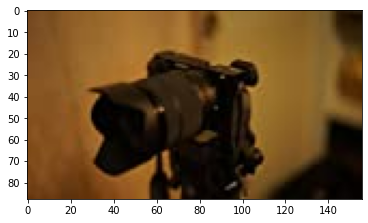

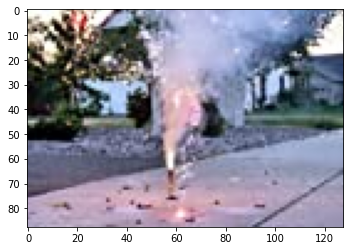

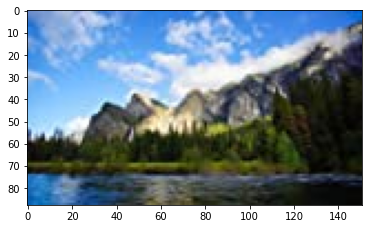

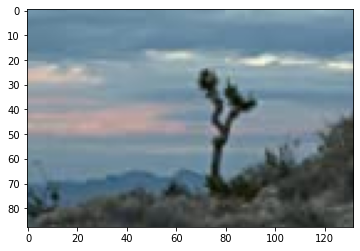

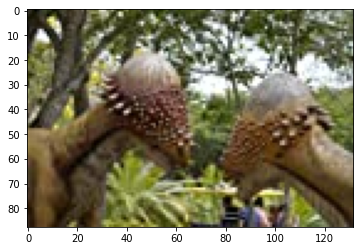

In [15]:
### THIS PART SHOWS THE PROBLEMS WITH SOME PRODUCTS - SUCH AS CAMERA PHOTOS BEING RANDOMLY TAKEN PHOTOS
# Plotting images for object B00007E7JU
obj_image = new_df1.loc[new_df1.asin == 'B00I8BICCG'].reset_index(drop = True)
#print(obj_image)
print("Category of the image is: ", df.loc[df.asin == 'B00I8BICCG']['category'].head(1).values)
for i in range(5):
    plt.figure()
    #print(obj_image['image'].values)
    show_image_from_url(obj_image['image'].loc[random.randint(0,len(obj_image)-1)])

### Getting arrays for images out

In [16]:
#create function to obtain image data and convert into generator
def get_image_data(img_url):
    #url_list = url_list.replace('\'','').replace('[','').replace(']','').split(',')
    #img_list = []
    #print(len(url_list))
    try:
    #Download from image url and import it as a numpy array
        response = urllib.request.urlopen(img_url)
        image = np.asarray(bytearray(response.read()), dtype="uint8")
    #print(1)
    #print(image.shape)
    #Read the numpy arrays as color images in OpenCV
        image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)
    #image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    #print(image_bgr.shape)
    #Resize the image to 35x35x3 pixels size - review images are much bigger -> but they have been converted as well 
        if image.shape[0]> 1000:
            image = cv2.resize(image_bgr, (35, 35))
        else:
            image = np.nan
    #img_list.append(image)
        return (img_url,image)
    except:
        return None

In [17]:
%%time
# Cleaning garbage values
gc.collect()

#print(df_model.shape)
df_model = df_model.dropna(how = 'any')
#print(df_model.shape)
n_loops = len(df_model)//10000
print(n_loops)
len_df = len(df_model)
append_df = pd.DataFrame(columns = ['image','loaded_img'])

for i in range(n_loops+1):
# Applying Image generator
    if i * 10000 + 10000 < len(df_model):
        urls = df_model[i*10000:i*10000+10000].image.values
        #print(len(urls))
        result = pd.DataFrame(Pool(10).map(get_image_data, urls), columns = ['image','loaded_img'])
        append_df = append_df.append(result, True)
    else:
        urls = df_model[i*10000:len_df+1].image.values
        result = pd.DataFrame(Pool(10).map(get_image_data, urls), columns = ['image','loaded_img'])
        append_df = append_df.append(result, True)   
    print(i, "Complete!")   

#print(append_df)
df_model_final = df_model.merge(append_df, how = 'left', on = 'image')
df_model_final = df_model_final.dropna(how = 'any')
df_model_final.shape
#df_model_final.to_csv("Model_Input_data_35x35_14tags.csv", index = False)

7
0 Complete!
1 Complete!
2 Complete!
3 Complete!
4 Complete!
5 Complete!
6 Complete!
7 Complete!
CPU times: user 3.96 s, sys: 3.56 s, total: 7.53 s
Wall time: 16min 10s


(52254, 18)

In [18]:
df_input = df_model_final
df_input.drop(columns = ['asin','category','image'], axis = 1, inplace = True)
df_input.columns.values

array(['accessories', 'accessories & supplies',
       'audio & video accessories', 'bags', 'cables & interconnects',
       'camera & photo', 'cases & sleeves',
       'computer accessories & peripherals', 'computer components',
       'computers & accessories', 'headphones', 'laptop accessories',
       'portable audio & video', 'tablet accessories', 'loaded_img'],
      dtype=object)

### Building model - Vanilla

In [19]:
# Inspiration for this architecture: VGG neural network

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(35,35, 3), padding = 'same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(tags.shape[1], activation='sigmoid')) # output layer = number of tags

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr = 0.0005),
              metrics=['accuracy'])

# checkpoint
filepath="model_best_vanilla.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [21]:
dataset = df_input[['loaded_img']]
y = df_input.drop('loaded_img',axis = 1)
# Randomly splitting onto train-test datasets
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train = np.array(X_train.loaded_img.tolist())
X_val = np.array(X_val.loaded_img.tolist())

In [22]:
X_train

array([[[[  8,  10,  11],
         [ 11,  13,  14],
         [ 13,  15,  16],
         ...,
         [ 81,  78,  80],
         [ 78,  75,  77],
         [ 70,  69,  73]],

        [[  8,  10,  11],
         [ 11,  13,  14],
         [ 13,  15,  16],
         ...,
         [ 96,  93,  95],
         [ 90,  87,  89],
         [ 79,  78,  82]],

        [[  8,  11,  11],
         [ 11,  13,  14],
         [ 13,  15,  16],
         ...,
         [113, 110, 112],
         [101,  99, 100],
         [ 86,  85,  89]],

        ...,

        [[  9,  11,  11],
         [  7,   9,   9],
         [  5,   7,   7],
         ...,
         [ 29,  28,  30],
         [ 29,  28,  30],
         [ 26,  26,  26]],

        [[  9,  11,  11],
         [  7,   9,   9],
         [  7,   9,   9],
         ...,
         [ 28,  27,  29],
         [ 28,  27,  29],
         [ 24,  24,  24]],

        [[  9,  11,  11],
         [  7,   9,   9],
         [  8,  10,  10],
         ...,
         [ 26,  25,  27],
        

In [23]:
#n = len(df_input) #Size of data
#X_train = np.array(df_input.loaded_img.tolist())
model.fit(X_train, y_train,        # Training data
          batch_size=512,          # Batch size 
          epochs=250,               # Epochs to train for
          verbose=1,               # Displaying progress
          validation_data=(X_val,y_val),    # 10% validation split for checking movement on validation data
          callbacks=callbacks_list # This parameter ensures that the model weights are saved whenever validation loss decreases
         )

Train on 39973 samples, validate on 4442 samples
Epoch 1/250
39973/39973 [==============================] - 7s 172us/step - loss: 1.0403 - accuracy: 0.7882 - val_loss: 0.3791 - val_accuracy: 0.8749

Epoch 00001: val_loss improved from inf to 0.37912, saving model to model_best_vanilla.hdf5
Epoch 2/250
39973/39973 [==============================] - 2s 60us/step - loss: 0.3975 - accuracy: 0.8616 - val_loss: 0.3550 - val_accuracy: 0.8796

Epoch 00002: val_loss improved from 0.37912 to 0.35498, saving model to model_best_vanilla.hdf5
Epoch 3/250
39973/39973 [==============================] - 2s 61us/step - loss: 0.3746 - accuracy: 0.8733 - val_loss: 0.3452 - val_accuracy: 0.8797

Epoch 00003: val_loss improved from 0.35498 to 0.34516, saving model to model_best_vanilla.hdf5
Epoch 4/250
39973/39973 [==============================] - 2s 60us/step - loss: 0.3653 - accuracy: 0.8760 - val_loss: 0.3552 - val_accuracy: 0.8798

Epoch 00004: val_loss did not improve from 0.34516
Epoch 5/250
39973/3

39973/39973 [==============================] - 2s 59us/step - loss: 0.3173 - accuracy: 0.8854 - val_loss: 0.3200 - val_accuracy: 0.8839

Epoch 00037: val_loss did not improve from 0.31570
Epoch 38/250
39973/39973 [==============================] - 2s 62us/step - loss: 0.3167 - accuracy: 0.8856 - val_loss: 0.3162 - val_accuracy: 0.8858

Epoch 00038: val_loss did not improve from 0.31570
Epoch 39/250
39973/39973 [==============================] - 2s 60us/step - loss: 0.3157 - accuracy: 0.8859 - val_loss: 0.3142 - val_accuracy: 0.8853

Epoch 00039: val_loss improved from 0.31570 to 0.31423, saving model to model_best_vanilla.hdf5
Epoch 40/250
39973/39973 [==============================] - 2s 59us/step - loss: 0.3149 - accuracy: 0.8858 - val_loss: 0.3146 - val_accuracy: 0.8855

Epoch 00040: val_loss did not improve from 0.31423
Epoch 41/250
39973/39973 [==============================] - 3s 71us/step - loss: 0.3142 - accuracy: 0.8862 - val_loss: 0.3153 - val_accuracy: 0.8858

Epoch 00041: v

39973/39973 [==============================] - 2s 59us/step - loss: 0.2895 - accuracy: 0.8933 - val_loss: 0.3083 - val_accuracy: 0.8886

Epoch 00075: val_loss improved from 0.30848 to 0.30829, saving model to model_best_vanilla.hdf5
Epoch 76/250
39973/39973 [==============================] - 2s 60us/step - loss: 0.2890 - accuracy: 0.8931 - val_loss: 0.3082 - val_accuracy: 0.8884

Epoch 00076: val_loss improved from 0.30829 to 0.30815, saving model to model_best_vanilla.hdf5
Epoch 77/250
39973/39973 [==============================] - 2s 59us/step - loss: 0.2878 - accuracy: 0.8938 - val_loss: 0.3087 - val_accuracy: 0.8887

Epoch 00077: val_loss did not improve from 0.30815
Epoch 78/250
39973/39973 [==============================] - 2s 61us/step - loss: 0.2872 - accuracy: 0.8937 - val_loss: 0.3089 - val_accuracy: 0.8884

Epoch 00078: val_loss did not improve from 0.30815
Epoch 79/250
39973/39973 [==============================] - 2s 59us/step - loss: 0.2865 - accuracy: 0.8941 - val_loss: 

39973/39973 [==============================] - 3s 66us/step - loss: 0.2630 - accuracy: 0.9016 - val_loss: 0.3077 - val_accuracy: 0.8903

Epoch 00115: val_loss improved from 0.30810 to 0.30775, saving model to model_best_vanilla.hdf5
Epoch 116/250
39973/39973 [==============================] - 2s 59us/step - loss: 0.2615 - accuracy: 0.9020 - val_loss: 0.3105 - val_accuracy: 0.8901

Epoch 00116: val_loss did not improve from 0.30775
Epoch 117/250
39973/39973 [==============================] - 2s 60us/step - loss: 0.2609 - accuracy: 0.9018 - val_loss: 0.3094 - val_accuracy: 0.8897

Epoch 00117: val_loss did not improve from 0.30775
Epoch 118/250
39973/39973 [==============================] - 2s 61us/step - loss: 0.2602 - accuracy: 0.9020 - val_loss: 0.3101 - val_accuracy: 0.8896

Epoch 00118: val_loss did not improve from 0.30775
Epoch 119/250
39973/39973 [==============================] - 2s 62us/step - loss: 0.2615 - accuracy: 0.9018 - val_loss: 0.3092 - val_accuracy: 0.8898

Epoch 0011

39973/39973 [==============================] - 2s 61us/step - loss: 0.2457 - accuracy: 0.9072 - val_loss: 0.3121 - val_accuracy: 0.8893

Epoch 00155: val_loss did not improve from 0.30775
Epoch 156/250
39973/39973 [==============================] - 2s 60us/step - loss: 0.2446 - accuracy: 0.9075 - val_loss: 0.3151 - val_accuracy: 0.8894

Epoch 00156: val_loss did not improve from 0.30775
Epoch 157/250
39973/39973 [==============================] - 2s 60us/step - loss: 0.2451 - accuracy: 0.9073 - val_loss: 0.3133 - val_accuracy: 0.8902

Epoch 00157: val_loss did not improve from 0.30775
Epoch 158/250
39973/39973 [==============================] - 2s 59us/step - loss: 0.2459 - accuracy: 0.9071 - val_loss: 0.3126 - val_accuracy: 0.8892

Epoch 00158: val_loss did not improve from 0.30775
Epoch 159/250
39973/39973 [==============================] - 2s 61us/step - loss: 0.2437 - accuracy: 0.9078 - val_loss: 0.3129 - val_accuracy: 0.8897

Epoch 00159: val_loss did not improve from 0.30775
Epoc


Epoch 00195: val_loss did not improve from 0.30775
Epoch 196/250
39973/39973 [==============================] - 2s 60us/step - loss: 0.2360 - accuracy: 0.9107 - val_loss: 0.3144 - val_accuracy: 0.8909

Epoch 00196: val_loss did not improve from 0.30775
Epoch 197/250
39973/39973 [==============================] - 2s 60us/step - loss: 0.2338 - accuracy: 0.9113 - val_loss: 0.3138 - val_accuracy: 0.8908

Epoch 00197: val_loss did not improve from 0.30775
Epoch 198/250
39973/39973 [==============================] - 2s 60us/step - loss: 0.2342 - accuracy: 0.9112 - val_loss: 0.3149 - val_accuracy: 0.8910

Epoch 00198: val_loss did not improve from 0.30775
Epoch 199/250
39973/39973 [==============================] - 2s 60us/step - loss: 0.2356 - accuracy: 0.9104 - val_loss: 0.3117 - val_accuracy: 0.8905

Epoch 00199: val_loss did not improve from 0.30775
Epoch 200/250
39973/39973 [==============================] - 2s 60us/step - loss: 0.2360 - accuracy: 0.9105 - val_loss: 0.3137 - val_accurac

39973/39973 [==============================] - 2s 60us/step - loss: 0.2298 - accuracy: 0.9128 - val_loss: 0.3145 - val_accuracy: 0.8913

Epoch 00236: val_loss did not improve from 0.30775
Epoch 237/250
39973/39973 [==============================] - 3s 66us/step - loss: 0.2289 - accuracy: 0.9137 - val_loss: 0.3117 - val_accuracy: 0.8910

Epoch 00237: val_loss did not improve from 0.30775
Epoch 238/250
39973/39973 [==============================] - 3s 67us/step - loss: 0.2281 - accuracy: 0.9134 - val_loss: 0.3156 - val_accuracy: 0.8915

Epoch 00238: val_loss did not improve from 0.30775
Epoch 239/250
39973/39973 [==============================] - 2s 61us/step - loss: 0.2287 - accuracy: 0.9135 - val_loss: 0.3127 - val_accuracy: 0.8907

Epoch 00239: val_loss did not improve from 0.30775
Epoch 240/250
39973/39973 [==============================] - 2s 61us/step - loss: 0.2295 - accuracy: 0.9126 - val_loss: 0.3130 - val_accuracy: 0.8910

Epoch 00240: val_loss did not improve from 0.30775
Epoc

### Testing Model - Vanilla

In [57]:
# Load best model
model = load_model('/kaggle/working/model_best_vanilla.hdf5')
print("Model load complete!")

X_test_array = np.array(X_test.loaded_img.tolist())
prediction_train = model.predict(X_train)
prediction_val = model.predict(X_val)
prediction_test = model.predict(X_test_array)

#labels
labels_train = (prediction_train > 0.5).astype(np.int)
labels_val = (prediction_val > 0.5).astype(np.int)
labels_test = (prediction_test > 0.5).astype(np.int)

print("Accuracy of train tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_train), labels_train)*100)
print("Accuracy of validation tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_val), labels_val)*100)
print("Accuracy of test tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_test), labels_test)*100)
print("The accuracy numbers are subset accuracy! i.e a sample is correct only if ALL the classes are predicted correctly!")
print("We are going to use Hemming Score to judge the model.")

Model load complete!
Accuracy of train tags (at 0.5 threshold) are:  23.490856328021415
Accuracy of validation tags (at 0.5 threshold) are:  16.636650157586672
Accuracy of test tags (at 0.5 threshold) are:  16.660288302079344
The accuracy numbers are subset accuracy! i.e a sample is correct only if ALL the classes are predicted correctly!
We are going to use Hemming Score to judge the model.


### Calculating Hamming Score for data

In [58]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    https://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

labels_train = (prediction_train > 0.5).astype(np.int)
labels_val = (prediction_val > 0.5).astype(np.int)
labels_test = (prediction_test > 0.5).astype(np.int)

print("The Hamming score is the ratio of [intersection of 1's]/[union of 1's]; where intersection and union is between predicted and true data.")
print("Hamming score of train tags (at 0.5 threshold) are: ", hamming_score(np.array(y_train), labels_train))
print("Hamming score of validation tags (at 0.5 threshold) are: ", hamming_score(np.array(y_val), labels_val))
print("Hamming score of test tags (at 0.5 threshold) are: ", hamming_score(np.array(y_test), labels_test))

The Hamming score is the ratio of [intersection of 1's]/[union of 1's]; where intersection and union is between predicted and true data.
Hamming score of train tags (at 0.5 threshold) are:  0.3203337252645536
Hamming score of validation tags (at 0.5 threshold) are:  0.22058006903797087
Hamming score of test tags (at 0.5 threshold) are:  0.22359144448696686


In [59]:
seq = np.arange(0.05, 0.95, 0.025)
scr={}
for i in seq:
    labels_val = (prediction_val > i).astype(np.int)
    score = hamming_score(np.array(y_val), labels_val)
    scr[i] = score
    print("Threshold: ",i , " Score: ", score)

Threshold:  0.05  Score:  0.1874942831944183
Threshold:  0.07500000000000001  Score:  0.21191878372765358
Threshold:  0.10000000000000002  Score:  0.2370350627160623
Threshold:  0.12500000000000003  Score:  0.2596627733165328
Threshold:  0.15000000000000002  Score:  0.27757757838239605
Threshold:  0.17500000000000004  Score:  0.29413623921728377
Threshold:  0.20000000000000007  Score:  0.3046147702665037
Threshold:  0.22500000000000003  Score:  0.3081575223515791
Threshold:  0.25000000000000006  Score:  0.31144969018674556
Threshold:  0.2750000000000001  Score:  0.3077051306790163
Threshold:  0.3000000000000001  Score:  0.3028590724898695
Threshold:  0.32500000000000007  Score:  0.2980714392916104
Threshold:  0.3500000000000001  Score:  0.2881359747861324
Threshold:  0.3750000000000001  Score:  0.27446720696383015
Threshold:  0.4000000000000001  Score:  0.25817574666066334
Threshold:  0.4250000000000001  Score:  0.2519698334083746
Threshold:  0.4500000000000001  Score:  0.2387137925859

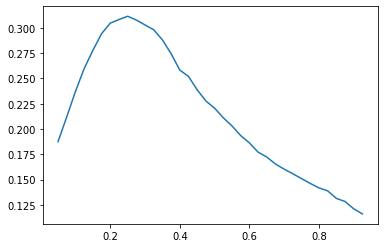

In [60]:
plt.plot(list(scr.keys()),list(scr.values()))

## For vanilla model, we get the best Hamming Score (31.52) at threshold of 0.25

In [61]:
# Selecting best threshold from above
labels_test = (prediction_test > 0.25).astype(np.int)

print("Accuracy of test tags (at best threshold) are: ", accuracy_score(np.array(y_test), labels_test)*100)
print("Hamming score of test tags (at best threshold) are: ", hamming_score(np.array(y_test), labels_test))

Accuracy of test tags (at best threshold) are:  16.46893736445975
Hamming score of test tags (at best threshold) are:  0.31522940851299064


In [62]:
# Below are the count of tags identified
print("The predicted test tags data looks as follows:")
print(">0: ",len(np.where(np.sum(labels_test, axis = 1)>0)[0]))
print(">1: ",len(np.where(np.sum(labels_test, axis = 1)>1)[0]))
print(">2: ",len(np.where(np.sum(labels_test, axis = 1)>2)[0]))
print(">3: ",len(np.where(np.sum(labels_test, axis = 1)>3)[0]))

print("The actual test data looks as follows:")
print(">0: ",len(np.where(np.sum(np.array(y_test), axis = 1)>0)[0]))
print(">1: ",len(np.where(np.sum(np.array(y_test), axis = 1)>1)[0]))
print(">2: ",len(np.where(np.sum(np.array(y_test), axis = 1)>2)[0]))
print(">3: ",len(np.where(np.sum(np.array(y_test), axis = 1)>3)[0]))

The predicted test tags data looks as follows:
>0:  7638
>1:  3353
>2:  1256
>3:  879
The actual test data looks as follows:
>0:  7053
>1:  3717
>2:  1353
>3:  938


### Building model - Pre-trained: VGG16

In [30]:
#model = Sequential()
densenn = VGG16(include_top = False, weights='imagenet',input_shape = (35,35,3))

output = densenn.layers[-1].output
#output = Flatten()(output)
dense_model = Model(densenn.input, output)

# Setting the model to be non-trainable
dense_model.trainable = False
for layer in dense_model.layers:
    layer.trainable = False
    
# Checking to ensure the same
layers = [(layer, layer.name, layer.trainable) for layer in dense_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

58892288/58889256 [==============================] - 1s 0us/step


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [31]:
model = Sequential()
model.add(dense_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(tags.shape[1], activation='sigmoid')) # output layer = number of tags
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 14)                1806      
Total params: 14,782,158
Trainable params: 67,470
Non-trainable params: 14,714,688
_________________________________________________________________


In [32]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr = 0.0005),
              metrics=['accuracy'])

# checkpoint
filepath="model_best_pretrained.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [33]:
dataset = df_input[['loaded_img']]
y = df_input.drop('loaded_img',axis = 1)
# Randomly splitting onto train-test datasets
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train = np.array(X_train.loaded_img.tolist())
X_val = np.array(X_val.loaded_img.tolist())

In [34]:
#n = len(df_input) #Size of data
#X_train = np.array(df_input.loaded_img.tolist())
model.fit(X_train, y_train,        # Training data
          batch_size=512,          # Batch size 
          epochs=75,               # Epochs to train for
          verbose=1,               # Displaying progress
          validation_data=(X_val,y_val),    # 10% validation split for checking movement on validation data
          callbacks=callbacks_list # This parameter ensures that the model weights are saved whenever validation loss decreases
         )

Train on 39973 samples, validate on 4442 samples
Epoch 1/75
39973/39973 [==============================] - 5s 127us/step - loss: 2.4963 - accuracy: 0.7568 - val_loss: 0.8672 - val_accuracy: 0.8202

Epoch 00001: val_loss improved from inf to 0.86716, saving model to model_best_pretrained.hdf5
Epoch 2/75
39973/39973 [==============================] - 4s 90us/step - loss: 0.8005 - accuracy: 0.7822 - val_loss: 0.5130 - val_accuracy: 0.8240

Epoch 00002: val_loss improved from 0.86716 to 0.51298, saving model to model_best_pretrained.hdf5
Epoch 3/75
39973/39973 [==============================] - 4s 91us/step - loss: 0.5217 - accuracy: 0.8124 - val_loss: 0.4204 - val_accuracy: 0.8572

Epoch 00003: val_loss improved from 0.51298 to 0.42041, saving model to model_best_pretrained.hdf5
Epoch 4/75
39973/39973 [==============================] - 4s 90us/step - loss: 0.4334 - accuracy: 0.8491 - val_loss: 0.3784 - val_accuracy: 0.8743

Epoch 00004: val_loss improved from 0.42041 to 0.37844, saving mo

39973/39973 [==============================] - 4s 90us/step - loss: 0.3050 - accuracy: 0.8906 - val_loss: 0.3149 - val_accuracy: 0.8868

Epoch 00034: val_loss improved from 0.31528 to 0.31487, saving model to model_best_pretrained.hdf5
Epoch 35/75
39973/39973 [==============================] - 4s 90us/step - loss: 0.3041 - accuracy: 0.8909 - val_loss: 0.3154 - val_accuracy: 0.8867

Epoch 00035: val_loss did not improve from 0.31487
Epoch 36/75
39973/39973 [==============================] - 4s 89us/step - loss: 0.3033 - accuracy: 0.8908 - val_loss: 0.3155 - val_accuracy: 0.8869

Epoch 00036: val_loss did not improve from 0.31487
Epoch 37/75
39973/39973 [==============================] - 4s 99us/step - loss: 0.3015 - accuracy: 0.8913 - val_loss: 0.3155 - val_accuracy: 0.8868

Epoch 00037: val_loss did not improve from 0.31487
Epoch 38/75
39973/39973 [==============================] - 4s 92us/step - loss: 0.3014 - accuracy: 0.8913 - val_loss: 0.3153 - val_accuracy: 0.8872

Epoch 00038: va

39973/39973 [==============================] - 4s 90us/step - loss: 0.2694 - accuracy: 0.8999 - val_loss: 0.3294 - val_accuracy: 0.8862

Epoch 00075: val_loss did not improve from 0.31487


### Testing Model - Pre-trained

In [63]:
# Load best model
model = load_model('/kaggle/working/model_best_pretrained.hdf5')
print("Model load complete!")

X_test_array = np.array(X_test.loaded_img.tolist())
prediction_train = model.predict(X_train)
prediction_val = model.predict(X_val)
prediction_test = model.predict(X_test_array)

#labels
labels_train = (prediction_train > 0.5).astype(np.int)
labels_val = (prediction_val > 0.5).astype(np.int)
labels_test = (prediction_test > 0.5).astype(np.int)

print("Accuracy of train tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_train), labels_train)*100)
print("Accuracy of validation tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_val), labels_val)*100)
print("Accuracy of test tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_test), labels_test)*100)
print("The accuracy numbers are subset accuracy! i.e a sample is correct only if ALL the classes are predicted correctly!")
print("We are going to use Hemming Score to judge the model.")

Model load complete!
Accuracy of train tags (at 0.5 threshold) are:  15.858204287894328
Accuracy of validation tags (at 0.5 threshold) are:  14.137775776677172
Accuracy of test tags (at 0.5 threshold) are:  14.15996938384998
The accuracy numbers are subset accuracy! i.e a sample is correct only if ALL the classes are predicted correctly!
We are going to use Hemming Score to judge the model.


### Calculating Hamming Score for data

In [64]:
labels_train = (prediction_train > 0.5).astype(np.int)
labels_val = (prediction_val > 0.5).astype(np.int)
labels_test = (prediction_test > 0.5).astype(np.int)

print("The Hamming score is the ratio of [intersection of 1's]/[union of 1's]; where intersection and union is between predicted and true data.")
print("Hamming score of train tags (at 0.5 threshold) are: ", hamming_score(np.array(y_train), labels_train))
print("Hamming score of validation tags (at 0.5 threshold) are: ", hamming_score(np.array(y_val), labels_val))
print("Hamming score of test tags (at 0.5 threshold) are: ", hamming_score(np.array(y_test), labels_test))

The Hamming score is the ratio of [intersection of 1's]/[union of 1's]; where intersection and union is between predicted and true data.
Hamming score of train tags (at 0.5 threshold) are:  0.22647870646019394
Hamming score of validation tags (at 0.5 threshold) are:  0.19816524088248536
Hamming score of test tags (at 0.5 threshold) are:  0.20303093810556497


In [65]:
seq = np.arange(0.05, 0.95, 0.025)
scr = {}
for i in seq:
    labels_val = (prediction_val > i).astype(np.int)
    score = hamming_score(np.array(y_val), labels_val)
    scr[i] = score
    print("Threshold: ",i , " Score: ", score)

Threshold:  0.05  Score:  0.17599863866185345
Threshold:  0.07500000000000001  Score:  0.20306222430828463
Threshold:  0.10000000000000002  Score:  0.22479170236937007
Threshold:  0.12500000000000003  Score:  0.24571209594847593
Threshold:  0.15000000000000002  Score:  0.2646738785752743
Threshold:  0.17500000000000004  Score:  0.2809117223513891
Threshold:  0.20000000000000007  Score:  0.2839675457865462
Threshold:  0.22500000000000003  Score:  0.281880570027801
Threshold:  0.25000000000000006  Score:  0.27976887288008406
Threshold:  0.2750000000000001  Score:  0.27599483287236554
Threshold:  0.3000000000000001  Score:  0.2723655153191398
Threshold:  0.32500000000000007  Score:  0.2658873094487682
Threshold:  0.3500000000000001  Score:  0.2568014193520722
Threshold:  0.3750000000000001  Score:  0.24398061791127978
Threshold:  0.4000000000000001  Score:  0.23620205398683564
Threshold:  0.4250000000000001  Score:  0.22325904247336034
Threshold:  0.4500000000000001  Score:  0.21601380759

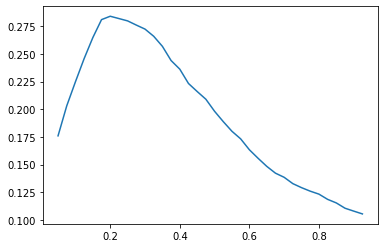

In [66]:
plt.plot(list(scr.keys()),list(scr.values()))

## We get the best Hamming Score (29.16) at threshold of 0.20

In [67]:
# Selecting best threshold from above
labels_test = (prediction_test > 0.20).astype(np.int)

print("Accuracy of test tags (at best threshold) are: ", accuracy_score(np.array(y_test), labels_test)*100)
print("Hamming score of test tags (at best threshold) are: ", hamming_score(np.array(y_test), labels_test))

Accuracy of test tags (at best threshold) are:  10.677382319173363
Hamming score of test tags (at best threshold) are:  0.291640164841466


In [68]:
# Below are the count of tags identified
print("The predicted test tags data looks as follows:")
print(">0: ",len(np.where(np.sum(labels_test, axis = 1)>0)[0]))
print(">1: ",len(np.where(np.sum(labels_test, axis = 1)>1)[0]))
print(">2: ",len(np.where(np.sum(labels_test, axis = 1)>2)[0]))
print(">3: ",len(np.where(np.sum(labels_test, axis = 1)>3)[0]))

print("The actual test data looks as follows:")
print(">0: ",len(np.where(np.sum(np.array(y_test), axis = 1)>0)[0]))
print(">1: ",len(np.where(np.sum(np.array(y_test), axis = 1)>1)[0]))
print(">2: ",len(np.where(np.sum(np.array(y_test), axis = 1)>2)[0]))
print(">3: ",len(np.where(np.sum(np.array(y_test), axis = 1)>3)[0]))

The predicted test tags data looks as follows:
>0:  7814
>1:  5514
>2:  2435
>3:  1776
The actual test data looks as follows:
>0:  7053
>1:  3717
>2:  1353
>3:  938


## Pre Trained Model: Densenet

In [41]:
#model = Sequential()
densenn = densenet.DenseNet121(include_top = False, weights='imagenet',input_shape = (35,35,3))

output = densenn.layers[-1].output
#output = Flatten()(output)
dense_model = Model(densenn.input, output)

# Setting the model to be non-trainable
dense_model.trainable = False
for layer in dense_model.layers:
    layer.trainable = False
    
# Checking to ensure the same
layers = [(layer, layer.name, layer.trainable) for layer in dense_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

29089792/29084464 [==============================] - 0s 0us/step


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_2,False
1,<keras.layers.convolutional.ZeroPadding2D obje...,zero_padding2d_1,False
2,<keras.layers.convolutional.Conv2D object at 0...,conv1/conv,False
3,<keras.layers.normalization.BatchNormalization...,conv1/bn,False
4,<keras.layers.core.Activation object at 0x7f71...,conv1/relu,False
...,...,...,...
422,<keras.layers.core.Activation object at 0x7f71...,conv5_block16_1_relu,False
423,<keras.layers.convolutional.Conv2D object at 0...,conv5_block16_2_conv,False
424,<keras.layers.merge.Concatenate object at 0x7f...,conv5_block16_concat,False
425,<keras.layers.normalization.BatchNormalization...,bn,False


In [42]:
model = Sequential()
model.add(dense_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(tags.shape[1], activation='sigmoid')) # output layer = number of tags
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 1, 1, 1024)        7037504   
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 14)                1806      
Total params: 7,170,510
Trainable params: 133,006
Non-trainable params: 7,037,504
_________________________________________________________________


In [43]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr = 0.0005),
              metrics=['accuracy'])

# checkpoint
filepath="model_best_pretrained_densenet.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [44]:
#n = len(df_input) #Size of data
#X_train = np.array(df_input.loaded_img.tolist())
model.fit(X_train, y_train,        # Training data
          batch_size=512,          # Batch size 
          epochs=75,               # Epochs to train for
          verbose=1,               # Displaying progress
          validation_data=(X_val,y_val),    # 10% validation split for checking movement on validation data
          callbacks=callbacks_list # This parameter ensures that the model weights are saved whenever validation loss decreases
         )

Train on 39973 samples, validate on 4442 samples
Epoch 1/75
39973/39973 [==============================] - 19s 483us/step - loss: 0.4300 - accuracy: 0.8468 - val_loss: 1.8831 - val_accuracy: 0.8759

Epoch 00001: val_loss improved from inf to 1.88311, saving model to model_best_pretrained_densenet.hdf5
Epoch 2/75
39973/39973 [==============================] - 6s 141us/step - loss: 0.3585 - accuracy: 0.8771 - val_loss: 1.7031 - val_accuracy: 0.8786

Epoch 00002: val_loss improved from 1.88311 to 1.70314, saving model to model_best_pretrained_densenet.hdf5
Epoch 3/75
39973/39973 [==============================] - 6s 140us/step - loss: 0.3425 - accuracy: 0.8805 - val_loss: 1.6389 - val_accuracy: 0.8796

Epoch 00003: val_loss improved from 1.70314 to 1.63892, saving model to model_best_pretrained_densenet.hdf5
Epoch 4/75
39973/39973 [==============================] - 6s 143us/step - loss: 0.3340 - accuracy: 0.8822 - val_loss: 1.4941 - val_accuracy: 0.8783

Epoch 00004: val_loss improved fro

39973/39973 [==============================] - 6s 138us/step - loss: 0.2654 - accuracy: 0.9011 - val_loss: 1.8792 - val_accuracy: 0.8673

Epoch 00040: val_loss did not improve from 1.46991
Epoch 41/75
39973/39973 [==============================] - 6s 149us/step - loss: 0.2637 - accuracy: 0.9019 - val_loss: 1.8554 - val_accuracy: 0.8683

Epoch 00041: val_loss did not improve from 1.46991
Epoch 42/75
39973/39973 [==============================] - 6s 144us/step - loss: 0.2625 - accuracy: 0.9021 - val_loss: 1.8855 - val_accuracy: 0.8667

Epoch 00042: val_loss did not improve from 1.46991
Epoch 43/75
39973/39973 [==============================] - 6s 138us/step - loss: 0.2623 - accuracy: 0.9021 - val_loss: 1.8486 - val_accuracy: 0.8658

Epoch 00043: val_loss did not improve from 1.46991
Epoch 44/75
39973/39973 [==============================] - 6s 138us/step - loss: 0.2605 - accuracy: 0.9023 - val_loss: 1.8138 - val_accuracy: 0.8670

Epoch 00044: val_loss did not improve from 1.46991
Epoch 4

## Testing Pre trained Model: DenseNet

In [69]:
# Load best model
model = load_model('/kaggle/working/model_best_pretrained_densenet.hdf5')
print("Model load complete!")

X_test_array = np.array(X_test.loaded_img.tolist())
prediction_train = model.predict(X_train)
prediction_val = model.predict(X_val)
prediction_test = model.predict(X_test_array)

#labels
labels_train = (prediction_train > 0.5).astype(np.int)
labels_val = (prediction_val > 0.5).astype(np.int)
labels_test = (prediction_test > 0.5).astype(np.int)

print("Accuracy of train tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_train), labels_train)*100)
print("Accuracy of validation tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_val), labels_val)*100)
print("Accuracy of test tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_test), labels_test)*100)
print("The accuracy numbers are subset accuracy! i.e a sample is correct only if ALL the classes are predicted correctly!")
print("We are going to use Hemming Score to judge the model.")

Model load complete!
Accuracy of train tags (at 0.5 threshold) are:  10.509593975933756
Accuracy of validation tags (at 0.5 threshold) are:  10.378208014407925
Accuracy of test tags (at 0.5 threshold) are:  10.588085214950887
The accuracy numbers are subset accuracy! i.e a sample is correct only if ALL the classes are predicted correctly!
We are going to use Hemming Score to judge the model.


In [70]:
labels_train = (prediction_train > 0.5).astype(np.int)
labels_val = (prediction_val > 0.5).astype(np.int)
labels_test = (prediction_test > 0.5).astype(np.int)

print("The Hamming score is the ratio of [intersection of 1's]/[union of 1's]; where intersection and union is between predicted and true data.")
print("Hamming score of train tags (at 0.5 threshold) are: ", hamming_score(np.array(y_train), labels_train))
print("Hamming score of validation tags (at 0.5 threshold) are: ", hamming_score(np.array(y_val), labels_val))
print("Hamming score of test tags (at 0.5 threshold) are: ", hamming_score(np.array(y_test), labels_test))

The Hamming score is the ratio of [intersection of 1's]/[union of 1's]; where intersection and union is between predicted and true data.
Hamming score of train tags (at 0.5 threshold) are:  0.14971355665073924
Hamming score of validation tags (at 0.5 threshold) are:  0.14671319225574067
Hamming score of test tags (at 0.5 threshold) are:  0.15169026661563975


In [71]:
seq = np.arange(0.05, 0.95, 0.025)
scr = {}
for i in seq:
    labels_val = (prediction_val > i).astype(np.int)
    score = hamming_score(np.array(y_val), labels_val)
    scr[i] = score
    print("Threshold: ",i , " Score: ", score)

Threshold:  0.05  Score:  0.19688203511931562
Threshold:  0.07500000000000001  Score:  0.18722797538646255
Threshold:  0.10000000000000002  Score:  0.1814235329431187
Threshold:  0.12500000000000003  Score:  0.17664340387212968
Threshold:  0.15000000000000002  Score:  0.17416704187303017
Threshold:  0.17500000000000004  Score:  0.17221596878283055
Threshold:  0.20000000000000007  Score:  0.16880159087498123
Threshold:  0.22500000000000003  Score:  0.165068287558157
Threshold:  0.25000000000000006  Score:  0.16465556055830707
Threshold:  0.2750000000000001  Score:  0.1619915953774576
Threshold:  0.3000000000000001  Score:  0.15951523337835807
Threshold:  0.32500000000000007  Score:  0.15747035869728349
Threshold:  0.3500000000000001  Score:  0.1554179798889389
Threshold:  0.3750000000000001  Score:  0.15359822902596426
Threshold:  0.4000000000000001  Score:  0.15228500675371454
Threshold:  0.4250000000000001  Score:  0.15074666066336484
Threshold:  0.4500000000000001  Score:  0.15059657

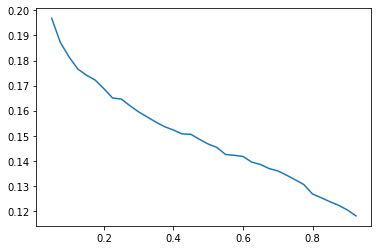

In [72]:
plt.plot(list(scr.keys()),list(scr.values()))

## We get the best Hamming Score (20.36) at threshold of 0.05

In [73]:
# Selecting best threshold from above
labels_test = (prediction_test > 0.05).astype(np.int)

print("Accuracy of test tags (at best threshold) are: ", accuracy_score(np.array(y_test), labels_test)*100)
print("Hamming score of test tags (at best threshold) are: ", hamming_score(np.array(y_test), labels_test))

Accuracy of test tags (at best threshold) are:  11.4938129863503
Hamming score of test tags (at best threshold) are:  0.20363566781477233


In [74]:
# Below are the count of tags identified
print("The predicted test tags data looks as follows:")
print(">0: ",len(np.where(np.sum(labels_test, axis = 1)>0)[0]))
print(">1: ",len(np.where(np.sum(labels_test, axis = 1)>1)[0]))
print(">2: ",len(np.where(np.sum(labels_test, axis = 1)>2)[0]))
print(">3: ",len(np.where(np.sum(labels_test, axis = 1)>3)[0]))

print("The actual test data looks as follows:")
print(">0: ",len(np.where(np.sum(np.array(y_test), axis = 1)>0)[0]))
print(">1: ",len(np.where(np.sum(np.array(y_test), axis = 1)>1)[0]))
print(">2: ",len(np.where(np.sum(np.array(y_test), axis = 1)>2)[0]))
print(">3: ",len(np.where(np.sum(np.array(y_test), axis = 1)>3)[0]))

The predicted test tags data looks as follows:
>0:  5711
>1:  458
>2:  141
>3:  40
The actual test data looks as follows:
>0:  7053
>1:  3717
>2:  1353
>3:  938
